In [2]:
# Import necessary Libraries
import os
import cv2 as cv
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from PIL import Image
from torchvision.io import read_image
import torch.nn as nn
import torch.nn.functional as F
import random
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import shutil
import numpy as np
from scipy import linalg
from torchvision.models import inception_v3, resnet18
import pandas as pd
import matplotlib.pyplot as plt
import re
from torch.utils.data import random_split
from sklearn.metrics import f1_score
import copy
from torch.optim import lr_scheduler
from torchvision import models

data_loc = '/home/kawada-kuka/siddharth/ADRL/data_aug_butterfly'

## Data Preperation

In [2]:
# Resizing the images to 128*128
subfolders = [f.path for f in os.scandir(data_loc) if f.is_dir()]
c = 1
for folder in subfolders:
    
    for filename in os.listdir(folder):
        c+=1
        img = cv.imread(os.path.join(folder, filename))
        if img.shape != (128, 128, 3):
            print('Resizing image: ', os.path.join(folder, filename))
            img = cv.resize(img, (128, 128))
            cv.imwrite(os.path.join(folder, filename), img)
            print("Resized shape is: ", img.shape)
        
print("total_datapoints===>",c)

Resizing image:  /home/kawada-kuka/siddharth/ADRL/assignment-1/Butterfly/train/Image_3069.jpg
Resized shape is:  (128, 128, 3)
Resizing image:  /home/kawada-kuka/siddharth/ADRL/assignment-1/Butterfly/train/Image_612.jpg
Resized shape is:  (128, 128, 3)
Resizing image:  /home/kawada-kuka/siddharth/ADRL/assignment-1/Butterfly/train/Image_6226.jpg
Resized shape is:  (128, 128, 3)
Resizing image:  /home/kawada-kuka/siddharth/ADRL/assignment-1/Butterfly/train/Image_2511.jpg
Resized shape is:  (128, 128, 3)
Resizing image:  /home/kawada-kuka/siddharth/ADRL/assignment-1/Butterfly/train/Image_6100.jpg
Resized shape is:  (128, 128, 3)
Resizing image:  /home/kawada-kuka/siddharth/ADRL/assignment-1/Butterfly/train/Image_1471.jpg
Resized shape is:  (128, 128, 3)
Resizing image:  /home/kawada-kuka/siddharth/ADRL/assignment-1/Butterfly/train/Image_259.jpg
Resized shape is:  (128, 128, 3)
Resizing image:  /home/kawada-kuka/siddharth/ADRL/assignment-1/Butterfly/train/Image_5549.jpg
Resized shape is:  

In [3]:
# Function to flip images
def copy_folders_and_flip_images(src_dir, dest_dir):
    if os.path.exists(dest_dir):
        shutil.rmtree(dest_dir)
    
    shutil.copytree(src_dir, dest_dir)
    
    for root, dirs, files in os.walk(dest_dir):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:    
                    flipped_img = img.transpose(Image.FLIP_LEFT_RIGHT)
                    file_name, ext = os.path.splitext(file)
                    flipped_file_path = os.path.join(root, f"{file_name}_flipped{ext}")
                    flipped_img.save(flipped_file_path)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

In [4]:
source_directory = "/home/kawada-kuka/siddharth/ADRL/assignment-1/Butterfly"
destination_directory = "/home/kawada-kuka/siddharth/ADRL/data_aug_butterfly"

copy_folders_and_flip_images(source_directory, destination_directory)

## Dataset class 

In [3]:
class ButterflyDataset(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data_folder = data_folder
        self.subfolders = [f.path for f in os.scandir(data_folder) if f.is_dir()]
        self.data = []
        self.label_map = {}
        for i, folder in enumerate(self.subfolders):
            for filename in os.listdir(folder):
                image_path = os.path.join(folder, filename)
                label_name = folder.split('/')[-1]
                self.label_map[label_name] = i
                self.data.append((image_path,i))          
        random.shuffle(self.data)
        
    def __len__(self):
        return len(self.data)
    
    def transform(self, img):
        img_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        return img_transform(img)
    
    def __getitem__(self, idx):
        if isinstance(idx, int):  
            img = cv.imread(self.data[idx][0])  
            label = self.data[idx][1] 
            img = self.transform(img)  
            return img, label
        
        elif isinstance(idx, slice):  
            indices = range(*idx.indices(len(self.data)))
            batch_imgs = []
            batch_labels = []
            for i in indices:
                img = cv.imread(self.data[i][0])  
                img = self.transform(img)  
                batch_imgs.append(img)
                batch_labels.append(self.data[i][1])
            return torch.stack(batch_imgs), batch_labels

        elif isinstance(idx, list):  
            batch_imgs = []
            batch_labels = []
            for i in idx:
                img = cv.imread(self.data[i][0])  
                img = self.transform(img)  
                batch_imgs.append(img)
                batch_labels.append(self.data[i][0])
            
            # Return batch of images and labels
            return torch.stack(batch_imgs), batch_labels

In [11]:
sample_dataset = ButterflyDataset(data_loc)
sample_dataset[0:10][0].shape

torch.Size([10, 3, 128, 128])

## Q1. DC GAN

In [5]:
class Model(nn.Module):
    def __init__(self, feature_maps_g, latent_dim, img_channels, feature_maps_d):
        super(Model, self).__init__()
      
        self.generator = Generator(feature_maps=feature_maps_g, latent_dim=latent_dim, img_channels=img_channels)
        self.discriminator = Discriminator(img_channels=img_channels, feature_maps=feature_maps_d)
    
    def generate(self, z):
        return self.generator(z)

    def discriminate(self, images):
        return self.discriminator(images)

#Architecture for Generator
class Generator(nn.Module):
    def __init__(self, feature_maps=1024, latent_dim=100, img_channels=3):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            # Input: latent vector 
            nn.ConvTranspose2d(latent_dim, feature_maps, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(feature_maps),
            nn.ReLU(True),

            # First layer
            nn.ConvTranspose2d(feature_maps, feature_maps // 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps // 2),
            nn.ReLU(True),

            # Second layer
            nn.ConvTranspose2d(feature_maps // 2, feature_maps // 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps // 4),
            nn.ReLU(True),

            # Third layer
            nn.ConvTranspose2d(feature_maps // 4, feature_maps // 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps // 8),
            nn.ReLU(True),

            # Fourth layer
            nn.ConvTranspose2d(feature_maps // 8, feature_maps // 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps // 16),
            nn.ReLU(True),

            # Fifth layer
            nn.ConvTranspose2d(feature_maps // 16, img_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()  # Tanh activation for image output in range [-1, 1]
        )
    
    def forward(self, x):
        # x = self.fc1(x)
        # x = self.leaky_relu(x)
        x = x.view(x.size(0), -1, 1, 1)  # Reshape the latent vector into (batch_size, latent_dim, 1, 1)
        return self.generator(x)
    
    
#Architecture for Discriminator
class Discriminator(nn.Module):
    def __init__(self, img_channels=3, feature_maps=64):
        super(Discriminator, self).__init__()
 
        self.discriminator = nn.Sequential(
            # Input
            nn.Conv2d(img_channels, feature_maps, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True), 
 
            # Layer 2
            nn.Conv2d(feature_maps, feature_maps * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
 
            # Layer 3
            nn.Conv2d(feature_maps * 2, feature_maps * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),
 
            # Layer 4
            nn.Conv2d(feature_maps * 4, feature_maps * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps * 8),
            nn.LeakyReLU(0.2, inplace=True),
 
            # Layer 5
            nn.Conv2d(feature_maps * 8, feature_maps * 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps * 16),
            nn.LeakyReLU(0.2, inplace=True),
 
            # Layer 6
            nn.Conv2d(feature_maps * 16, 1, kernel_size=4, stride=1, padding=0, bias=False),
 
            #Output: Single value (real/fake), flatten to 1x1
            nn.Flatten(),
            nn.Sigmoid()
            # Output is a probability (real or fake)
        )
 
    def forward(self, x):
        x = self.discriminator(x)
        x = x.view(-1,1).squeeze(1)
        return x

## Training Loop

In [15]:
def train_model(data_loader, model, latent_dim, device, num_epochs=100, k=1, learning_rate=0.001):
    # Optimizers
    optimizer_G = optim.Adam(model.generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(model.discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    
    # Loss function
    criterion = nn.BCELoss()
    
    # Path to the loss file
    loss_path = f'/home/kawada-kuka/siddharth/ADRL/Losses/DCGAN_butterfly/DCGAN{k}.txt'
    os.makedirs(os.path.dirname(loss_path), exist_ok=True)
    # Check if the loss log file exists; if not, create it and add a header
    with open(loss_path, 'w') as loss_log_file:
        loss_log_file.write("Epoch, d_loss, g_loss\n")  # Write the header if the file doesn't exist
         

    for epoch in range(num_epochs):
        datapoints = 0
        total_gen_loss = 0
        total_disc_loss = 0

        # Use tqdm to show the progress bar with loss updates
        progress_bar = tqdm(enumerate(data_loader), total=len(data_loader), desc=f'Epoch [{epoch + 1}/{num_epochs}]')

        for i, (real_images, _) in progress_bar:
            real_images = real_images.to(device)

            # Train Discriminator k times
            for _ in range(k):
                optimizer_D.zero_grad()

                # Discriminator on real images
                real_preds = model.discriminate(real_images)
                d_loss_real = criterion(real_preds, torch.ones_like(real_preds))

                # Discriminator on fake images
                z = torch.randn(real_images.size(0), latent_dim).to(device)  # Latent vector
                fake_images = model.generate(z)

                fake_preds = model.discriminate(fake_images.detach())
                d_loss_fake = criterion(fake_preds, torch.zeros_like(fake_preds))  # Label for fake should be zeros

                d_loss = d_loss_real + d_loss_fake
                d_loss.backward()
                optimizer_D.step()

            # Train Generator once
            optimizer_G.zero_grad()

            z = torch.randn(real_images.size(0), latent_dim).to(device)  # Latent vector
            fake_images = model.generate(z)
            fake_preds = model.discriminate(fake_images)

            g_loss = criterion(fake_preds, torch.ones_like(fake_preds))  # Generator wants to fool the discriminator
            g_loss.backward()
            optimizer_G.step()

            total_disc_loss += d_loss.item()
            total_gen_loss += g_loss.item()

            datapoints += real_images.size(0)
            avg_disc_loss = total_disc_loss / datapoints
            avg_gen_loss = total_gen_loss / datapoints

            # Update tqdm description to include current losses
            progress_bar.set_postfix({
                'd_loss': f'{avg_disc_loss:.4f}',
                'g_loss': f'{avg_gen_loss:.4f}'
            })

        print(f'Epoch [{epoch + 1}/{num_epochs}], d_loss: {avg_disc_loss:.4f}, g_loss: {avg_gen_loss:.4f}')
        
        
        with open(loss_path, 'a') as loss_log_file:
            loss_log_file.write(f'{epoch + 1}, {avg_disc_loss:.4f}, {avg_gen_loss:.4f}\n')
            loss_log_file.flush()  # Force the data to be written to the file
        
        if epoch%50 == 0:
            # Create a folder named after the epoch number
            folder_name = f'/home/kawada-kuka/siddharth/ADRL/models/DCGAN_butterfly_{k}/epoch_{epoch+1}'
            os.makedirs(folder_name, exist_ok=True)

            # Save the generator and discriminator models in the folder
            torch.save(model.generator, os.path.join(folder_name, 'generator_best.pth'))
            torch.save(model.discriminator, os.path.join(folder_name, 'discriminator_best.pth'))

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
latent_dim = 100
img_channels = 3
feature_maps_g = 1024
feature_maps_d = 64
batch_size = 64
learning_rate = 0.0002
num_epochs = 100
k = 1

# Initialize model
model = Model(feature_maps_g=feature_maps_g, latent_dim=latent_dim, img_channels=img_channels, feature_maps_d=feature_maps_d)
model.to(device)

# DataLoader
data_loader = DataLoader(ButterflyDataset(data_loc), batch_size=batch_size, shuffle=True)

# Call the training function
train_model(data_loader, model, latent_dim, device, num_epochs=num_epochs, k=k, learning_rate=learning_rate)

Epoch [1/100]:  36%|███▋      | 106/291 [00:06<00:11, 16.44it/s, d_loss=0.0188, g_loss=0.1087]


KeyboardInterrupt: 

/tmp/ipykernel_5785/1704118.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen = torch.load(model_path).to('cpu')


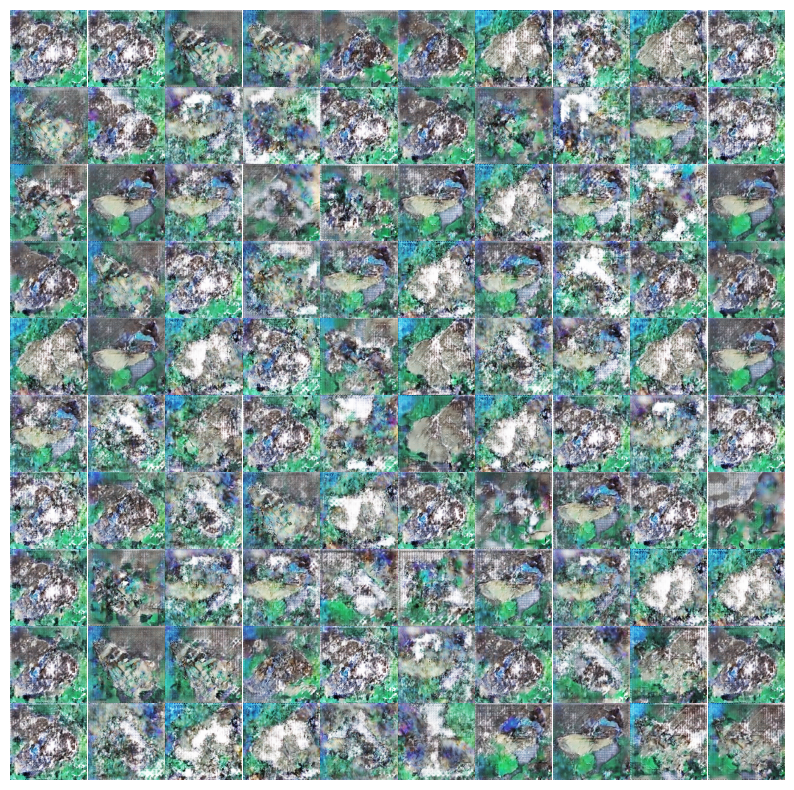

In [8]:
# Images of best model 
def plot_img_dcgan(model_path):
    gen = torch.load(model_path).to('cpu')

    fig, axes = plt.subplots(10, 10, figsize=(10, 10))

    with torch.no_grad():
        for i in range(10):
            for j in range(10):
                z = torch.randn(1, 100)  
                img = gen(z)  
                img = img.squeeze(0).permute(1, 2, 0).cpu().numpy()            
                
                img = (img + 1) * 127.5
                img = img.astype(np.uint8)
            
                axes[i, j].imshow(img)
                axes[i, j].axis('off')  

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

model_path = "/home/kawada-kuka/siddharth/ADRL/models/DCGAN_butterfly_1/epoch_2801/generator_best.pth"

plot_img_dcgan(model_path)